<a href="https://colab.research.google.com/github/singhvis29/Hands_On_LLM_WR/blob/main/Ch9_Multimodal_Large_Language_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install matplotlib transformers datasets accelerate sentence-transformers

### CLIP

In [2]:
from urllib.request import urlopen
from PIL import Image

# Load an AI-generated image of a puppy playing in the snow
puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
image = Image.open(urlopen(puppy_path)).convert("RGB")
caption = "a puppy playing in the snow"

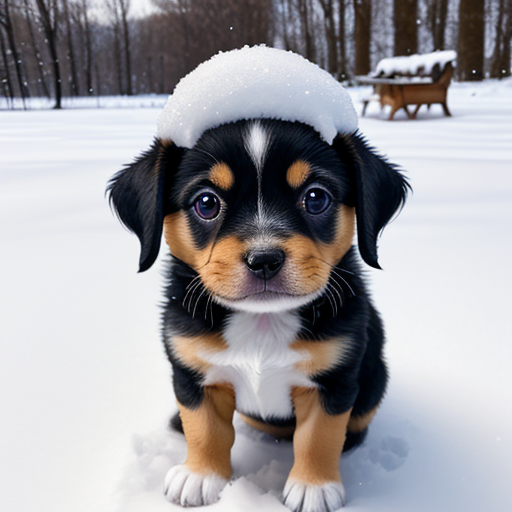

In [3]:
image